In [2]:
import matplotlib.pyplot as plt
import sys,os,random,copy
import tempfile
from os import system
import subprocess
import numpy as np
import pandas as pd



NN_bin = './disembl'
SG_bin = './sav_gol'


def JensenNet(sequence):
    outFile = tempfile.mktemp()
    inFile = tempfile.mktemp()

    open(inFile, 'w').write(sequence + '\n')
    # inFile = 'OC1.txt'
    # outFile ='OC2.txt'
    system(NN_bin + '< ' + inFile + ' >' + outFile)
    REM465 = []
    COILS = []
    HOTLOOPS = []
    resultsFile = open(outFile, 'r')
    results = resultsFile.readlines()
    resultsFile.close()
    for result in results:
        result = result.split()
        coil = round(float(result[0]), 6)
        COILS.append(coil)
        hotloop = round(float(result[1]), 6)
        HOTLOOPS.append(hotloop)
        rem465 = round(float(result[2]), 6)
        REM465.append(rem465)
    os.remove(inFile)
    os.remove(outFile)
    return COILS, HOTLOOPS, REM465


def new_smooth(window, derivative, predicted_raw):
    if len(predicted_raw) < 2 * window:
        window = len(predicted_raw) / 2
    elif window == 0:
        window = 1
    outFile = tempfile.mktemp()
    inFile = tempfile.mktemp()
    # inFile = 'oc1_test.txt'
    # outFile ='oc1_test_result.txt'
    with open(inFile, 'w') as filehandle:
        for e in predicted_raw:
            filehandle.write('%s\n' % e)
    system_call = SG_bin + ' -V0 -D' + str(derivative) + ' -n' + str(window) + ',' + str(
        window) + ' ' + inFile + ' >' + outFile

    system(system_call)
    SG_results = []
    resultsFile = open(outFile, 'r')
    results = resultsFile.readlines()
    resultsFile.close()

    for result in results:
        temp = round(float(result), 6)
        SG_results.append(temp)
    os.remove(outFile)
    os.remove(inFile)

    return SG_results


def generate_parents(sequence, num_parents=50,parents = set()):  # by default get 50 seq as the parents
    """generate parents for the GA by random shuffling the seq"""
    count = 0
    if not sequence:
        print('you do not have input')
        return
    while True:
        temp = list(sequence)
        random.shuffle(temp)
        temp = ''.join(temp)
        if temp not in parents:
            parents.add(temp)
            count += 1
        if count == num_parents:
            break
    return list(parents)


def point_transpose(seq, position):
    """given a position, we move the amino acid in that position to a random place"""
    if not seq or position < 0:
        print('illegal input, seq empty or position is minus')
        return
    temp = list(seq) # so We will working on temp, seq is not affected
    good_mutation = False

    all_pos = list(range(len(temp)-1))  # all positions from 1,2,3... end of the list
    if position in all_pos: # we do not want to to to the same position
        all_pos.remove(position)  # remove the position from which we pop the amino acide
    amino_acid = temp.pop(position)  # pop the amino acid at the position
    
    if not good_mutation:
        new_pos = random.choice(all_pos)  # choose new pos by random
        temp.insert(new_pos, amino_acid)  # insert the aa into the new postion
        temp = ''.join(temp)
        if temp != seq:
            if len(temp) != len(seq):
                print(""" making point from {}, to {}, 
                old position{},new position:{} double check """.format(seq, temp, position, new_pos))
            else:
                good_mutation = True
    # do we want to have a new one?
    return temp


def frag_transpose(seq, start, stop, to_shuffle):
    if not seq or (start < 0) or (stop - start <= 0) or stop >= len(
            seq):  # I do not want to use index more that the range
        print('illegal input, seq empty or start and stop positions are wrong')
        return

    temp = list(seq)
    good_mutation = False
    
    frag = temp[start: stop + 1]  # pop from temp
    left_over = temp[:start] + temp[stop + 1:]
  
    all_pos = list(range(len(left_over)))
    while not good_mutation:
        new_start = random.choice(all_pos)
        if to_shuffle:
            random.shuffle(frag)
        # print(frag)
        new_seq = left_over[:new_start] + frag + left_over[new_start:]
        new_seq = ''.join(new_seq)
        if new_seq != seq:
            good_mutation = True
    return new_seq


def frag_disperse(seq, start, stop): # start and stop is the index
    """ this one we will just disperse the orginal frag into a new list

    """

    if not seq or (start < 0) or ((stop - start) <= 0) or ((stop-start) >= (len(seq) - 1)):  # I do not want to use index more that the range
        print('illegal input, seq empty or start and stop positions are wrong')
        return
    
    good_mutation = False
    temp = list(seq) # a new oject so the original one is not affected
    frag = temp[start:stop+1]
    
    if start > 0:
        left_over = temp[:start] + temp[stop+1:]
    else:
        left_over = temp[stop+1:]
    #print('the frag to shuffle is{}, the left_over is:{}'.format(frag, left_over) )  
    all_pos = list(range(len(left_over)))  
    random.shuffle(frag)
    
    while not good_mutation:
        pos_needed = random.sample(all_pos, k=stop - start + 1)
        pos_needed.sort(reverse=True)  # sort it so I can insert from the revese manner
        #print(pos_needed)
        for idx, element in zip(pos_needed, frag):
            try: # I donot think I need, but somehow it tells me leftover is not a list
                #print('insert{} into idx{} of {}'.format(element,idx,left_over))
                left_over.insert(idx, element)
            except:
                print("""the related value for this, original iput seq:{} start:{} stop:{}
                intermediate: temp:{}, frag:{}, pos_needed{},
                final: idx{}, element:{}""".format(seq,start,stop,left_over,temp,frag,pos_needed, idx, element))
                raise ValueErorr('cannot insert into the list')
        t = ''.join(left_over)
        if t != seq:
            if len(left_over) != len(seq):
                print('double check orig{}, after disperse:{}, start:{}, stop:{}'.format(seq,left_over,start,stop))
            else:
                good_mutation = True

    return t


def fitness_one(seq, smooth_frame = 8, to_plot=False):
    _, _, raw = JensenNet(seq)
    temp_smooth = new_smooth(smooth_frame, 0, raw)
    if to_plot:
        plt.plot(temp_smooth)
        plt.axhline(y=0.5)
        plt.axvline(x=np.argmax(temp_smooth))
        plt.grid()
        plt.title('Disorder of ' + seq)
        plt.text(0, 0.35, 'mean disorder: {}'.format(round(np.mean(temp_smooth), 3)))
        plt.text(np.argmax(temp_smooth) + 1, max(temp_smooth) - 0.05, 'max:{}'.format(round(max(temp_smooth), 3)))
    return seq, np.mean(temp_smooth), np.argmax(temp_smooth), max(temp_smooth)


def scan_population(seqs,smooth_frame):  # return the sorted one and return the survial probability
    mean_fit, max_idx, max_fit = [], [], []
    for seq in seqs:
        _, one_mean_fit, one_max_idx, one_max_fit = fitness_one(seq,smooth_frame = smooth_frame)
        mean_fit.append(one_mean_fit)
        max_idx.append(one_max_idx)
        max_fit.append(one_max_fit)

    prob = np.array(mean_fit)  # convert to numpy array
    idx = np.argsort(prob)  # get the rank the smallest one is in the top
    prob = 1 - prob[idx]  # sort probality and 1- so we reverse it the disorder score is 0-1
    prob = prob / prob.sum()  # survival probality we want to select the small value so 1-p

    seqs = [seqs[i] for i in idx]  # now everything is sorted based on the probability
    mean_fit = [mean_fit[i] for i in idx]
    max_idx = [max_idx[i] for i in idx]
    max_fit = [max_fit[i] for i in idx]
    # return prob as np.array, others are list
    return seqs, mean_fit, max_idx, max_fit, prob


def show_generation(seqs, mean_fit, max_idx, max_fit, prob):
    df = pd.DataFrame({'orignal seq': seqs, 'mean disorder score': mean_fit, 'survive probability': prob, \
                       'max disorder aa': max_idx, 'max_disorder socre': max_fit})
    return df

def roulette_wheel_selection(rate,prob):
    """ return a list of index which can be selected"""
    nums = int(rate * (prob.size)) # we want to have this many
    selected_index = np.random.choice(prob.size, nums, p=prob,replace = False)
    return selected_index # return selected_index as np.array


def retrive_seq(seqs, max_idx, idx):
    seqs = copy.deepcopy(np.array(seqs))
    max_idx = copy.deepcopy(np.array(max_idx))
    
    seqs_new = seqs[idx]
    max_idx_new = max_idx[idx]
    # so the oringal seq is not affected we have the new object
    return seqs_new, max_idx_new # return as np.array


def batch_point_tran(seqs, max_idx,ratio):  # we only need the original seq and where to generate
    # idx is the idx we should select
    # finish selection now call for mutation
    point_mutate = copy.deepcopy(seqs)
    to_mutate = int(len(point_mutate)*ratio)
    idx_to_mutate = np.random.choice(len(point_mutate), to_mutate,replace = False)
    
    for idx in idx_to_mutate:
        find = False
        while not find:
            result = point_transpose(point_mutate[idx], max_idx[idx])
            if result not in point_mutate:
                find = True
                point_mutate[idx] =result
                
    return list(point_mutate)


def correct_index(idx, nums, boundary): # boundar is the length of the array
    diff = nums // 2
    start = idx - diff
    stop = idx + diff

    if start <= 0:
        stop = nums - 1
        start = 0

    if stop >= boundary - 1:
        start = boundary - nums # start is minus-nums
        stop = boundary - 1

    return start, stop


def batch_frag_disp(seqs, max_idx,nums):
    frag_disp=[]
    boundary = len(seqs[0])
    for (seq, pos) in zip(seqs,max_idx):
        start,stop =correct_index(pos,nums,boundary)
        try:
            temp = frag_disperse(seq,start,stop)
            frag_disp.append(temp)
        except:
            print('the problem seq, the start, the stop', seq, start,stop)
            raise ValueError('cannot generate the mutation')
    return frag_disp

In [ ]:
 _, one_mean_fit, one_max_idx, one_max_fit = fitness_one(seq,smooth_frame = smooth_frame)

In [5]:
def rank(prob):
    """ return a list of index which can be selected"""
    rank = np.zeros(len(prob))
    t = 0
    for i in range(len(prob)-1,-1,-1):
        rank[t] = 5**i
        
        #print(rank[t])
        t += 1
    rank = rank / rank.sum() 
    return rank # return selected_index as np.array

In [79]:
rank(list(range(20)))

array([8.000000e-01, 1.600000e-01, 3.200000e-02, 6.400000e-03,
       1.280000e-03, 2.560000e-04, 5.120000e-05, 1.024000e-05,
       2.048000e-06, 4.096000e-07, 8.192000e-08, 1.638400e-08,
       3.276800e-09, 6.553600e-10, 1.310720e-10, 2.621440e-11,
       5.242880e-12, 1.048576e-12, 2.097152e-13, 4.194304e-14])

In [2]:
def evolution(seed, smooth_frame =8, total=1000, generation=20,keep_top = 10, point_ratio1 =0.5, \
              point_ratio2=1, frag_ratio1 = 0.3,frag_size1 =7, \
              frag_ratio2 = 0.1,frag_size2 = 3, min_foreign = 5   ):
    
    label ='generation'
    test_seq = generate_parents(seed, num_parents= total,parents = set())
    seqs, mean_fit, max_idx, max_fit, prob = scan_population(test_seq,smooth_frame)
    # if use rank selection
    prob = rank(prob)
    #print(mean_fit, prob)
    t = show_generation(seqs, mean_fit, max_idx, max_fit, prob)
    t[label] = -1
    best = t.head(1)
    for i in range(generation):
        idx = roulette_wheel_selection(point_ratio1,prob)  # 50% for point mutation
        new_seq,new_max_idx = retrive_seq(seqs, max_idx, idx) 
        
        new_seq =list(new_seq)
        new_max_idx =list(new_max_idx)
        top_count = 0
        for top_count in range(keep_top):
            if seqs[top_count] not in new_seq:
                new_seq.append(seqs[top_count])
                new_max_idx.append(new_max_idx[top_count])
                
        point_seq = batch_point_tran(new_seq, new_max_idx,point_ratio2)   

        idx = roulette_wheel_selection(frag_ratio1,prob)  
        new_seq,new_max_idx = retrive_seq(seqs, max_idx, idx)
        # force the top get choose
        top_count = 0
        new_seq =list(new_seq)
        new_max_idx =list(new_max_idx)
        for top_count in range(keep_top):
            if seqs[top_count] not in new_seq:
                new_seq.append(seqs[top_count])
                new_max_idx.append(new_max_idx[top_count])
                
        frag_seq1= batch_frag_disp(new_seq,new_max_idx,frag_size1)
        
        idx = roulette_wheel_selection(frag_ratio2,prob)  
        new_seq,new_max_idx = retrive_seq(seqs, max_idx, idx)
        
        # force
        new_seq =list(new_seq)
        new_max_idx =list(new_max_idx)
        top_count = 0
        for top_count in range(keep_top):
            if seqs[top_count] not in new_seq:
                new_seq.append(seqs[top_count])
                new_max_idx.append(new_max_idx[top_count])
                
        frag_seq2= batch_frag_disp(new_seq,new_max_idx,frag_size2)

        new_pop = set(point_seq + frag_seq1 + frag_seq2) 
        foreign_num = total-len(new_pop)
        foreign_num = foreign_num if foreign_num >min_foreign else min_foreign
        print('generation i introduce random', foreign_num)
        new_pop = generate_parents(seed, num_parents= foreign_num, parents= set(new_pop))
        
        # maintain the best 50
        print(new_pop[1])
        top_count = 0
        for top_count in range(keep_top):
            if seqs[top_count] not in new_pop:
                new_pop.append(seqs[top_count])
        print('final number of sequence for generate{}, is {}'.format(i, len(new_pop)))
        seqs, mean_fit, max_idx, max_fit, prob = scan_population(new_pop,smooth_frame)
        prob = rank(prob)
        temp = show_generation(seqs, mean_fit, max_idx, max_fit, prob)
        temp[label] = i
        best = pd.concat([best,temp.head(1)],ignore_index=True)  
        if i % 10 == 0:
            display(best)
        if i % 100 == 0:
            best.to_csv('best.csv')
    best.to_csv('best.csv')
    return best
        
        

In [3]:
def evolution2(seed, smooth_frame =8, total=1000, generation=20,keep_top = 10,\
              frag_ratio1 = 0.3,frag_size1 =3, \
              frag_ratio2 = 0.1,frag_size2 = 5, min_foreign = 5   ):
    
    label ='generation'
    test_seq = generate_parents(seed, num_parents= total,parents = set())
    seqs, mean_fit, max_idx, max_fit, prob = scan_population(test_seq,smooth_frame)
    t = show_generation(seqs, mean_fit, max_idx, max_fit, prob)
    t[label] = -1
    best = t.head(1)
    
    for i in range(generation):
        idx = roulette_wheel_selection(frag_ratio1,prob)  # 50% for point mutation
        new_seq,new_max_idx = retrive_seq(seqs, max_idx, idx) 
  
        # force the top get choose
        top_count = 0
        new_seq =list(new_seq)
        new_max_idx =list(new_max_idx)
        for top_count in range(keep_top):
            if seqs[top_count] not in new_seq:
                new_seq.append(seqs[top_count])
                new_max_idx.append(new_max_idx[top_count])
                
        frag_seq1= batch_frag_disp(new_seq,new_max_idx,frag_size1)
        
        idx = roulette_wheel_selection(frag_ratio2,prob)  
        new_seq,new_max_idx = retrive_seq(seqs, max_idx, idx) 
        top_count = 0
        new_seq =list(new_seq)
        new_max_idx =list(new_max_idx)
        for top_count in range(keep_top):
            if seqs[top_count] not in new_seq:
                new_seq.append(seqs[top_count])
                new_max_idx.append(new_max_idx[top_count]) 
        
        frag_seq2= batch_frag_disp(new_seq,new_max_idx,frag_size2)

        new_pop = set(frag_seq1 + frag_seq2) 
        foreign_num = total-len(new_pop)
        foreign_num = foreign_num if foreign_num >0 else min_foreign
        
        print('generation i introduce random', foreign_num)
        new_pop = generate_parents(seed, num_parents= foreign_num, parents= set(new_pop))
        
        # maintain the best 50
        print(new_pop[1])
        top_count = 0
        for top_count in range(keep_top):
            if seqs[top_count] not in new_pop:
                new_pop.append(seqs[top_count])
        print('final number of sequence for generate{}, is {}'.format(i, len(new_pop)))
        seqs, mean_fit, max_idx, max_fit, prob = scan_population(new_pop,smooth_frame)
        temp = show_generation(seqs, mean_fit, max_idx, max_fit, prob)
        temp[label] = i
        best = pd.concat([best,temp.head(1)],ignore_index=True)  
        if i % 10 == 0:
            display(best)
        if i % 100 == 0:
            best.to_csv('best.csv')
    best.to_csv('best.csv')
    return best

a = evolution2(mouse_oc1_short,smooth_frame =7, keep_top = 1,total=50,\
              frag_ratio1 = 0.2,frag_ratio2= 0.7,\
              frag_size1 =3, frag_size2 =7, generation =5000,min_foreign= 5 )
              
              best is 0.75

In [ ]:
mouse_oc1_short = 'KRKEQEHGKDRGNTP'
#seq = mouse_oc1_short
seq = 'PKEKDGNKRTHRGEQ'
boundary = len(mouse_oc1_short)
smooth_frame = 7
repeat = 10000
_, one_mean_fit, one_max_idx, one_max_fit = fitness_one(seq,smooth_frame = smooth_frame)
best_score = one_mean_fit
for i in range(repeat):   
    start,stop =correct_index(one_max_idx,3,boundary)
    #print(list(seq), seq[one_max_idx])
    new1 = frag_disperse(seq, start, stop)
    #print('new1 is{}, old seq is {}'.format(new1, seq))
    start,stop =correct_index(one_max_idx,5,boundary)
    new2 = frag_disperse(seq, start, stop)
    #print('new2 is{}, old seq is {}'.format(new2, seq))
    start,stop =correct_index(one_max_idx,7,boundary)
    new3 = frag_disperse(seq, start, stop)
    #print('new3 is{}, old seq is {}'.format(new3, seq))
    new4 = point_transpose(seq, one_max_idx)
    #print('new4 is{}, old seq is {}'.format(new4, seq))
    start,stop =correct_index(one_max_idx,7,boundary)
    new5 = frag_transpose(seq, start, stop, True)
   
    _, one_mean_fit1, one_max_idx1, one_max_fit1 = fitness_one(new1,smooth_frame = smooth_frame)
    _, one_mean_fit2, one_max_idx2, one_max_fit2 = fitness_one(new2,smooth_frame = smooth_frame)
    _, one_mean_fit3, one_max_idx3, one_max_fit3 = fitness_one(new3,smooth_frame = smooth_frame)
    _, one_mean_fit4, one_max_idx4, one_max_fit4 = fitness_one(new4,smooth_frame = smooth_frame)
    _, one_mean_fit5, one_max_idx5, one_max_fit5 = fitness_one(new5,smooth_frame = smooth_frame)
    
    score = np.array([one_mean_fit1,one_mean_fit2,one_mean_fit3,one_mean_fit4,one_mean_fit5])
    seq_array = np.array([new1,new2,new3,new4,new5])  
    max_pos = np.argmax(score)
    if np.max(score) < best_score:
        best_score = np.max(score)
        seq = seq_array[np.argmax(score)]      
    if i%100 == 0:
        print ('best score for round {},seq:{} is:{} '.format(i, seq, best_score))
        print(score, seq_array)
    #print(one_mean_fit1,one_mean_fit2,one_mean_fit3,one_mean_fit4)
    #trash, one_mean_fit, one_max_idx, one_max_fit = fitness_one(seq,smooth_frame = smooth_frame)



best 0.736 after 1100 rounds
random.seed(64)
np.random.seed(64)

a = evolution(mouse_oc1_short,smooth_frame =7, keep_top = 10,total=100,\
              point_ratio1= 0.1 ,frag_ratio1 = 0.2,frag_ratio2= 0.2,\
              frag_size1 =5, frag_size2 =7, generation =5000,min_foreign= 20 )
              
              
* 0.731  after 2000* random seed 46

a = evolution(mouse_oc1_short,smooth_frame =7, keep_top = 20,total=200,\
              point_ratio1= 0.1 ,frag_ratio1 = 0.3,frag_ratio2= 0.2,\
              frag_size1 =3, frag_size2 = 7 , generation =5000,min_foreign= 50 )
              
              

In [22]:
np.random.choice(5, 3, p=[0.8,0.1,0.05,0.025,0.025],replace = False)

array([0, 1, 2])

In [ ]:
mouse_oc1_long = 'STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE'
human_oc1_long ='STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE'
print(mouse_oc1_long == human_oc1_long)
mouse_oc1_short = 'KRKEQEHGKDRGNTP'
# test they use smooth window 7 for this 

random.seed(10)
np.random.seed(10)

a = evolution('CCCEQEQGCDCGCTC',smooth_frame =7, keep_top = 1,total= 100,\
              point_ratio1= 0.3 ,point_ratio2= 0.5,frag_ratio1 = 0.3,frag_ratio2= 0.3,\
              frag_size1 = 3, frag_size2 = 7 , generation =5000,min_foreign= 0 )

In [26]:
_, _, raw = JensenNet(mouse_oc1_short)
temp_smooth6 = new_smooth(6, 0, raw)
print(temp_smooth6)

temp_smooth7 = new_smooth(7, 0, raw)
print(temp_smooth7)

temp_smooth5 = new_smooth(5, 0, raw)
print(temp_smooth5)

#a,b,c,d = fitness_one(mouse_oc1_short,smooth_frame = 7,to_plot='True')
#print(a,b,c,d)

[0.889511, 0.854516, 0.80558, 0.850312, 0.69966, 0.845998, 0.766836, 0.760305, 0.764659, 0.755897, 0.597388, 0.855292, 0.855437, 0.856064, 0.819139]
[0.889511, 0.854516, 0.80558, 0.850312, 0.69966, 0.845998, 0.816267, 0.76479, 0.762722, 0.755897, 0.597388, 0.855292, 0.855437, 0.856064, 0.819139]
[0.889511, 0.854516, 0.80558, 0.850312, 0.69966, 0.806996, 0.776762, 0.761395, 0.753406, 0.768446, 0.597388, 0.855292, 0.855437, 0.856064, 0.819139]


In [ ]:
random.seed(0)
np.random.seed(0)

a = evolution('STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE',keep_top = 28,total=100,\
              point_ratio1= 0.1, frag_ratio1 = 0.3,frag_size1 = 9,frag_ratio2= 0.3,\
              generation =5000)

In [100]:
 oc1_long ='STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE'

In [120]:

long_start = oc1.find(oc1_long)
long_stop = long_start +len(oc1_long)-1
#oc1_long == oc1[long_start:long_stop+1]
first =oc1[0:long_start]
second =oc1[long_stop+1:]

long_mutant ='HSHSKRLEQHSHRHDPNGHHFLMHSVDHHHPHGTVAFTHH'
new_oc1 = first+ long_mutant +second
print(long_start)

115


In [197]:
def plot_2seq(oc1_full, mutant, short_start):
    """the mutantant is used to calculate without using other part of the protein
    """
    _, _, raw = JensenNet(oc1_full)
    temp_smooth = new_smooth(8, 0, raw)
    s_array =np.array(list(oc1_full))
    x_value = list(range(len(temp_smooth)))
    plt.figure(figsize=(16,4))
    plt.plot(x_value, temp_smooth, 'b.-',alpha = 0.8)
    idx =np.array(list(range(0,len(oc1_full),20)))
    l = [(str(x)+ '\n'+ str(y)) for x,y in zip(idx, s_array[idx])]
    plt.xticks(idx,l)
    plt.grid()
    plt.axhline(y = 0.5, c='r', alpha = 0.8)
    plt.axvline(x = short_start,c ='g' , ls ='--', alpha = 0.8)
    plt.axvline(x = short_start + len(mutant) -1 , c ='g', ls ='--', alpha = 0.8)
   
    _, _, raw2 = JensenNet(mutant)
    temp_smooth2 = new_smooth(7, 0, raw2)
    x1 = np.array(range(len(temp_smooth2)))
    x1 =x1+short_start
    plt.plot(x1, temp_smooth2,'m.-',alpha=0.5)

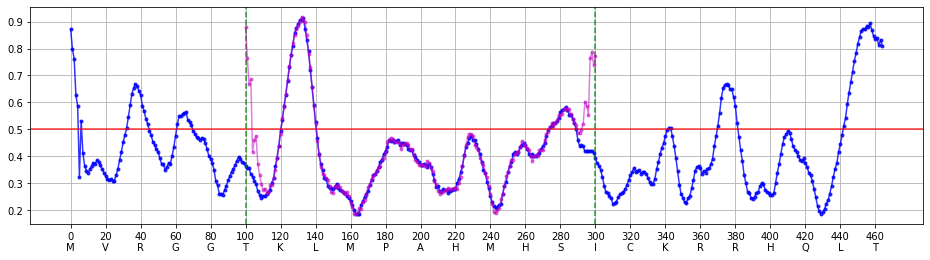

In [198]:
test_seq =oc1[100:301]
plot_2seq(oc1,test_seq,100)

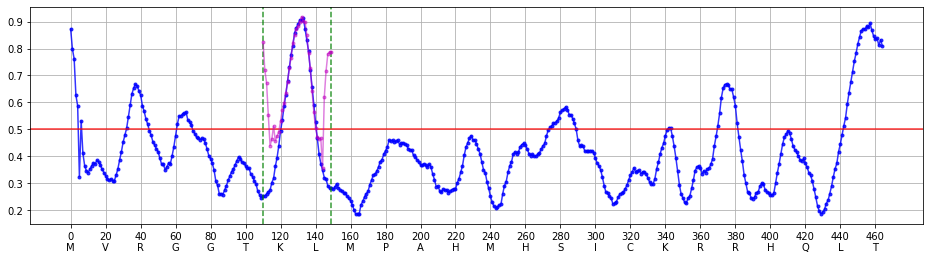

In [199]:
test_seq =oc1[110:150]
plot_2seq(oc1,test_seq,110)

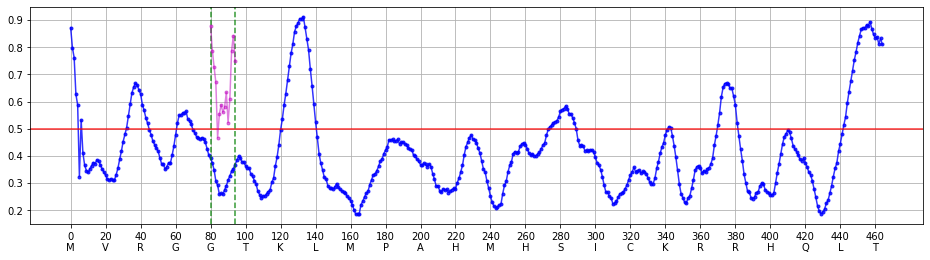

In [200]:
test_seq =oc1[80:95]
plot_2seq(oc1,test_seq,80)

In [208]:
def plot_2full(oc1_full, mutant, long_start):
    """
    the endogenous part is replaced by the frag of mutant. The result is than plotted
    """
    _, _, raw = JensenNet(oc1_full)
    temp_smooth = new_smooth(8, 0, raw)
    s_array =np.array(list(oc1_full))
    x_value = list(range(len(temp_smooth)))
    plt.figure(figsize=(16,4))
    plt.plot(x_value, temp_smooth, 'b.-',alpha = 0.8)
    idx =np.array(list(range(0,len(oc1_full),20)))
    l = [(str(x)+ '\n'+ str(y)) for x,y in zip(idx, s_array[idx])]
    plt.xticks(idx,l)
    plt.grid()
    plt.axhline(y = 0.5, c='r', alpha = 0.8)
    plt.axvline(x = long_start, c ='g' , ls ='--', alpha = 0.8)
    plt.axvline(x = long_start + len(mutant) -1 , c ='g', ls ='--', alpha = 0.8)
    
    first =oc1[0:long_start]
    second =oc1[long_start + len(mutant):]
    new_oc1 = first+ mutant +second
    print('mutant length',len(mutant),'length of the full',len(new_oc1))
    _, _, raw2 = JensenNet(new_oc1)
    temp_smooth2 = new_smooth(7, 0, raw2)
    plt.plot(temp_smooth2,'m.-',alpha=0.5)

mutant length 40 length of the full 465


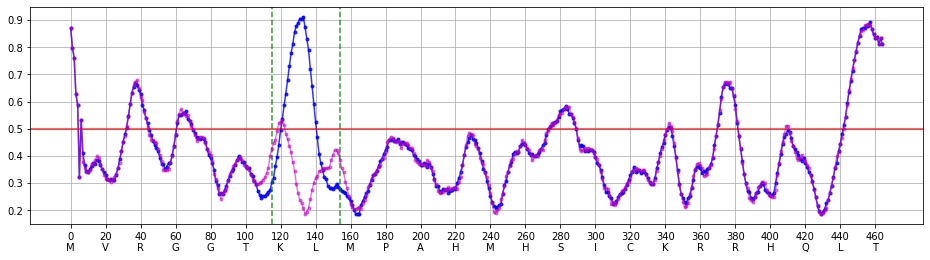

In [192]:
plot_2full(oc1,long_mutant,long_start)

In [152]:
oc1 ="""MNAQLTMEAIGELHGVSHEPVPAPADLLGGSPHARSSVGHRGSHLPPAHPRSMGMASLLD
GGSGGSDYHHHHRAPEHSLAGPLHPTMTMACETPPGMSMPTTYTTLTPLQPLPPISTVSD
KFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDERGLASMNNLYTPYHKDVAGMGQSLS
PLSGSGLGSIHNSQQGLPHYAHPGAAMPTDKMLTPNGFEAHHPAMLGRHGEQHLTPTSAG
MVPINGLPPHHPHAHLNAQGHGQLLGTAREPNPSVTGAQVSNGSNSGQMEEINTKEVAQR
ITTELKRYSIPQAIFAQRVLCRSQGTLSDLLRNPKPWSKLKSGRETFRRMWKWLQEPEFQ
RMSALRLAACKRKEQEHGKDRGNTPKKPRLVFTDVQRRTLHAIFKENKRPSKELQITISQ
QLGLELSTVSNFFMNARRRSLDKWQDEGGSNSGSSSSSSSTCTKA
""" 
oc1=''.join(oc1.split('\n'))
print(oc1[114:156])
long_mutant ='HSHSKRLEQHSHRHDPNGHHFLMHSVDHHHPHGTVAFTHH'
long_start = oc1.find('STVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDE')
first =oc1[0:long_start]
second =oc1[long_stop+1:]
new_oc1 = first+long_mutant +second
print(new_oc1[114:156])

ISTVSDKFPHHHHHHHHHHHPHHHQRLAGNVSGSFTLMRDER
IHSHSKRLEQHSHRHDPNGHHFLMHSVDHHHPHGTVAFTHHR


In [137]:
long_start

115

In [148]:
short_start = oc1.find('KRKEQEHGKDRGNTP')
print(short_start)

370


465
mutant length 15 length of the full 465


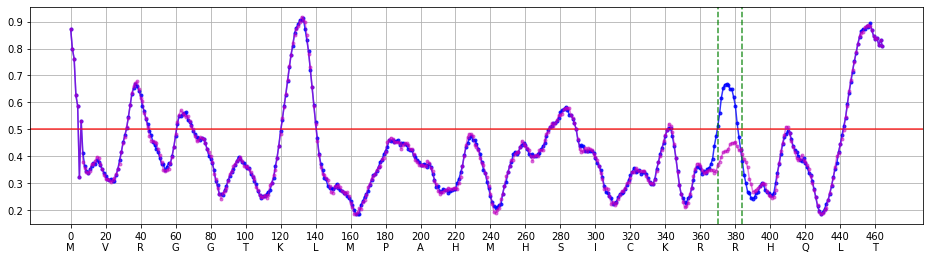

In [207]:
print(len(oc1))
plot_2full(oc1,'QKKFRETGRHDKNGE',370)

# a point mutation of the P to C or P to F to remove p
#QKKPRETGRHDKNGE


465
mutant length 15 length of the full 465


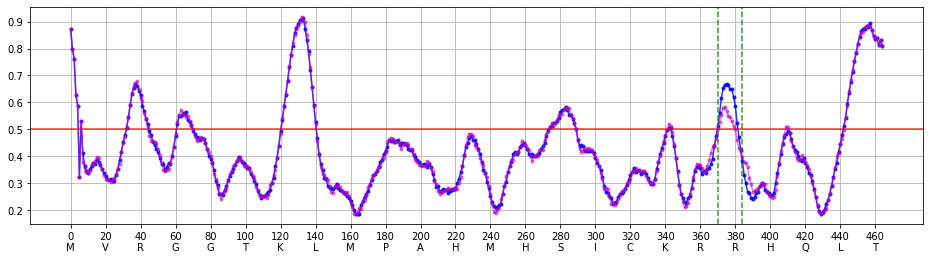

In [194]:
print(len(oc1))
plot_2full(oc1,'QKKPRETGRHDKNGE',370)

mutant length 15 length of the full 465


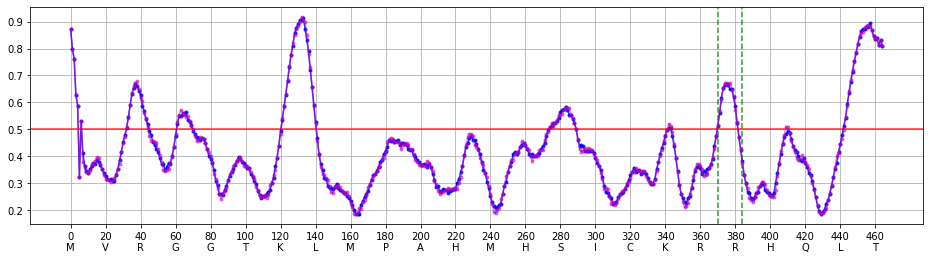

In [195]:
plot_2full(oc1,'KRKEQEHGKDRGNTP',370)

mutant length 40 length of the full 465


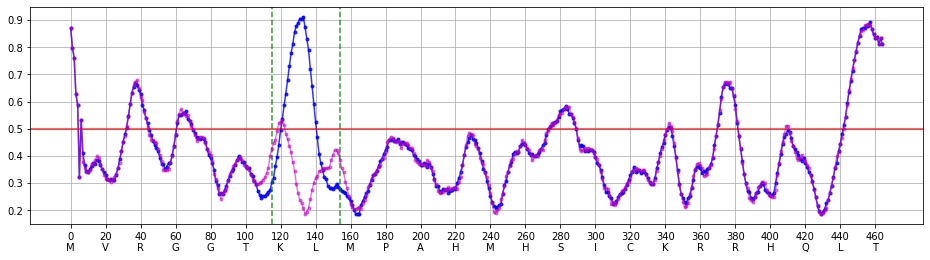

In [196]:
#long_mutant ='HSHSKRLEQHSHRHDPNGHHFLMHSVDHHHPHGTVAFTHH'
long_mutant = 'HSHSKRLEQWSHRHDPNGHHFLMHSVDHHHPHGTVAFTHH'
# single mutation of H to w to disrupt the simple complexity
plot_2full(oc1,long_mutant,long_start)

mutant length 40 length of the full 465


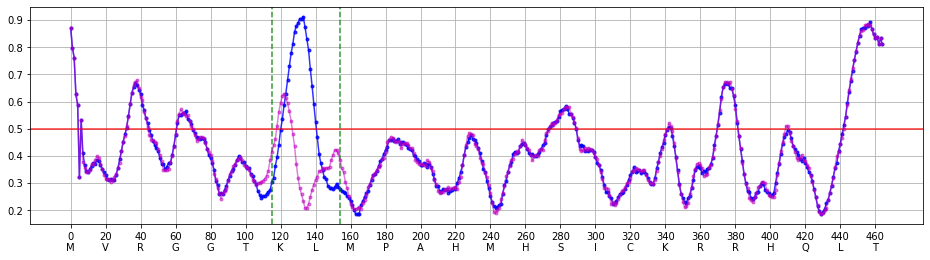

In [201]:
long_mutant ='HSHSKRLEQHSHRHDPNGHHFLMHSVDHHHPHGTVAFTHH'
#long_mutant = 'HSHSKRLEQWSHRHDPNGHHFLMHSVDHHHPHGTVAFTHH'
# single mutation of H to w to disrupt the simple complexity
plot_2full(oc1,long_mutant,long_start)